# Diverse Group Relative Policy Optimization (DGRPO)

## Background

GRPO explain with code and training example is [An overview of GRPO & DeepSeek-R1 Training with Open Source GRPO Model Fine Tuning](https://github.com/ALucek/GRPO-Training/tree/main) by Adam Lucek

# Group Relative Policy Optimization (GRPO)

<img src="https://i0.wp.com/chatgptfrancais.org/wp-content/uploads/2025/02/open-ai-o3-mini.jpg?resize=900%2C506&ssl=1" width=600>

DeepSeek-R1 has disrupted the AI community by providing a competitive, comparable, and completely open sourced alternative to OpenAI's original reasoning models. Before the DeepSeek team released their report, the methods and techniques used to enable long reflective **reasoning** capabilities in language models have been largely speculative.

While it's still not clear exactly how the private labs like OpenAI have achieved their own reasoning, DeepSeek fully outlines their technique in the paper [*DeepSeek-R1: Incentivizing Reasoning Capability in LLMs via
Reinforcement Learning*](https://arxiv.org/pdf/2501.12948).

Within the paper they outline the entire training pipeline for [DeepSeek-R1](https://huggingface.co/deepseek-ai/DeepSeek-R1) along with their breakthrough using a new reinforcement learning technique, Group Relative Policy Optimization (GRPO), originally outlined in [*DeepSeekMath: Pushing the Limits of Mathematical Reasoning in Open Language Models*](https://arxiv.org/pdf/2402.03300).

In this notebook we'll be show how GRPO is applied by covering:
1. How the Algorithm Works
2. The DeepSeek-R1 Training Pipeline
3. Applying GRPO Training Ourselves to Qwen-2.5-3B-Instruct

---
# How GRPO Works

<img src="https://community.aws/_next/image?url=https%3A%2F%2Fassets.community.aws%2Fa%2F2ra6RfOUylhUM8M3eDEMfDlB3l7%2FScre.webp%3FimgSize%3D1698x894&w=3840&q=75" width=600>

Group Relative Policy Optimization is a modified version of Proximal Policy Optimization (PPO), a popular reinforcement learning algorithm commonly used for techniques like Reinforcement Learning from Human Feedback (RLHF).

In PPO for LLM alignment, the process tends to follow:
1. Sample response from the policy model (i.e., the LLM being fine-tuned).
2. Compute total reward from a reward function(s)/model(s) (typically trained on human preference data or aligned to LLM behavior).
3. Compute KL (Kullback-Leibler) penalty using a reference model (often the original frozen model or a lagged training model) to ensure the policy update does not deviate too much.
4. Combine reward and KL penalty to compute the final reward used for training.
5. Use a separate value model (often the same LLM with an extra value head, or seperately trained value model) to estimate the value function (i.e., how good the current state-action pair is).
6. Compute the advantage function using Generalized Advantage Estimation (GAE) to determine how much better an action is compared to the expected value of the current state.
7. Update the policy using the PPO objective function.

GRPO modifies this by taking multiple samples for each **input prompt**, then computing rewards **relatively within each batch** rather than assigning absolute values.  

<img src="https://www.philschmid.de/static/blog/deepseek-r1/grpo.png" width=600>

<img src="https://i.imgur.com/xjMWlkC.png" width=600>

In GRPO, the process follows:  
1. Sample multiple responses from the policy model for the same input prompt.  
2. Compute rewards for each response using a reward function(s)/model(s).  
3. Normalize rewards within the group by computing the mean and standard deviation.  
4. Compute advantage values using the difference between a response’s reward and the group’s mean reward.
5. Compute KL penalty using a reference model to prevent excessive divergence.  
6. Use the GRPO objective function to update the policy, now optimizing for relative ranking instead of absolute values. This means GRPO cares about how well a response did compared to other responses for the same prompt, rather than trying to learn absolute reward values.

By **removing the need for a separate value model** and focusing on **group-relative scoring**, GRPO makes training more efficient while maintaining alignment with human feedback and training examples.

---
# How GRPO Was Applied

GRPO turned out to be a powerful algorithm for teaching LLMs to think through problems longer without explicitly defining any functions that encourage reasoning or thinking length.

DeepSeek originally began training their model purely using GRPO reinforcement learning on R1's predecessor, [DeepSeek-R1-Zero](https://huggingface.co/deepseek-ai/DeepSeek-R1-Zero). The setup for this included:

* Starting with the [DeepkSeek-V3 LLM](https://arxiv.org/pdf/2412.19437v1) as the base model
* Using the below prompt template:

<img src="https://i.postimg.cc/0yk4fgw3/Screenshot-2025-02-16-at-10-42-37-AM.png" width=600>

* Defining reward functions for **formatting** and **accuracy**

Notably, this initial approach does not rely on any supervised fine tuning (SFT) to try and explicitly train the model on reasoning examples or processes, rather relying on the RL environment to guide the LLM to learn this behavior itself. Additionally, the training dataset primarily consisted of examples with verifiable outcomes like math/code/logic based questions, as these outputs are much easier to verify the accuracy of for reward modeling.

<img src="https://miro.medium.com/v2/resize:fit:1400/0*DJUCCE_aN14OpSy4" width=600>

The result of this training was successful, with a few surprising observations as the model began to:
1. Exhibit the behavior of reflection- revisiting and reevaluating prior steps in it's thought process.
2. Consider and explore possible alternative methods for solving problems rather than sticking to a single or the first option.
3. Use more test-time compute and generate longer answers as it reflects and explores more possibilities, as shown above.

This proved DeepSeek's theory of being able to use purely RL to guide LLMs towards learning advanced reasoning capabilities, leading to the now famous *aha moment* observed during intermediate training runs.

<img src="https://bgr.com/wp-content/uploads/2025/01/deepseek-r1-aha-moment.jpg?quality=82&strip=all" width=600>

With the initial success of DeepSeek-R1-Zero, the team moved on to applying this in a more formalized LLM training and alignment pipeline.

<img src="https://miro.medium.com/v2/resize:fit:1400/1*aVbpOkbtbSznComBWkijsQ.png" width=600>

The training of DeepSeek-R1 follows a 4 step process:
1. **SFT with Long CoT Examples**: Fine tune DeepSeek-V3 with thousands of labeled reasoning examples gathered from DeepSeek-Zero, Human Annotators, and Few Shot synthetic data generation techniques.
2. **GRPO RL for Reasoning**: An initial training run using GRPO on reasoning-oriented examples (coding, math, science, logic) to enhance the model's reasoning capabilities.
3. **Rejection Sampling & SFT**: Post stage 2, the resulting checkpoint was used along with DeepSeek-V3 as a judge and V3's original training data to generate and augment additional training examples. This now includes non-reasoning specific data like writing, factual QA, and translation, resulting in 800k curated examples for general-purpose tasks. The model was then trained using SFT for 2 epochs on these examples.
4. **RL Alignment**: Finally, GRPO RL was employed again for the final harmlessness and helpfulness alignment. A combination of reasoning specific rewards and human preference model rewards, along with a final diverse mix of training data is used to create the end result DeepSeek-R1 model.

GRPO proved to be a powerful foundation for training reasoning capabilities LLMs as shown in DeepSeek-R1's development. Through group-relative scoring and removing the need for a value model, the team needed only rule-based rewards for accuracy and format validation to get initial reasoning results. Adding supervised fine-tuning before GRPO training made the process more stable and efficient compared to R1-Zero's pure RL approach. Their result matched OpenAI's o1-1217 performance but with significantly reduced compute requirements forgoing extra critic models and complex reward models. Most notably, GRPO's relative optimization enabled strong generalization of reasoning patterns from technical domains to broader tasks, suggesting that group-relative training may be particularly effective at teaching foundational reasoning capabilities in LLMs.

---
# Applying GRPO Ourselves

<img src="https://huggingface.co/datasets/trl-lib/documentation-images/resolve/main/grpo_visual.png" width=600>

Now that we have an understanding of GRPO and the way it's been applied to create the (current) best open source reasoning model- let's apply some of the techniques ourselves.

While we won't be [applying the full pipeline](https://github.com/huggingface/open-r1) in this example, we can take a base language model and use GRPO reinforcement learning to start training reasoning capabilities.

Below we will outline the process of training [Qwen2.5-3B-Instruct](https://huggingface.co/Qwen/Qwen2.5-3B-Instruct) on [GSM8K](https://huggingface.co/datasets/openai/gsm8k) math problems with GRPO and how this affects its' chain-of-thought reasoning ability.

The below code is a modified and annotated version of [Unsloth's original](https://docs.unsloth.ai/basics/reasoning-grpo-and-rl) documentation and code. Shoutout to the Han brothers for their incredible work! Click the link for more information and examples from Unsloth.

## Dependencies

We will be relying on [Unsloth](https://github.com/unslothai/unsloth), [vLLM](https://github.com/vllm-project/vllm) and [Transformers Reinforcement Learning (TRL)](https://huggingface.co/docs/trl/en/index) as the core packages for training and inferencing.

In [1]:
#%%capture
!pip uninstall unsloth -y
!pip install unsloth --no-binary numpy
!pip install vllm
!pip install --upgrade pillow
# If you are running this notebook locally (not colab), you need to install `diffusers` too
# !pip install diffusers

# Temporarily install a specific TRL nightly version that supports GRPO
!pip install git+https://github.com/huggingface/trl.git@e95f9fb74a3c3647b86f251b7e230ec51c64b72b

!pip install transformers

Found existing installation: unsloth 2025.3.18
Uninstalling unsloth-2025.3.18:
  Successfully uninstalled unsloth-2025.3.18
  Using cached unsloth-2025.3.18-py3-none-any.whl.metadata (46 kB)
Using cached unsloth-2025.3.18-py3-none-any.whl (192 kB)
  Cloning https://github.com/huggingface/trl.git (to revision e95f9fb74a3c3647b86f251b7e230ec51c64b72b) to /tmp/pip-req-build-vk8bjupo
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/trl.git /tmp/pip-req-build-vk8bjupo
  Running command git rev-parse -q --verify 'sha^e95f9fb74a3c3647b86f251b7e230ec51c64b72b'
  Running command git fetch -q https://github.com/huggingface/trl.git e95f9fb74a3c3647b86f251b7e230ec51c64b72b
  Running command git checkout -q e95f9fb74a3c3647b86f251b7e230ec51c64b72b
  Resolved https://github.com/huggingface/trl.git to commit e95f9fb74a3c3647b86f251b7e230ec51c64b72b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproje

## Unsloth TRL Patch

<img src="https://miro.medium.com/v2/resize:fit:898/0*tporAgJg5LLllQe_.png" width=250>

Unsloth's `PatchFastRL` modifies TRL (Transformer Reinforcement Learning) trainers to work efficiently with Unsloth's optimized models. The patch makes three key changes:

1. Patches the model unwrapping process for efficient generation during training
2. Modifies TRL trainers with Unsloth-specific optimizations, including things like:
   - Automatically handles mixed precision training (FP16/BF16) based on model config
   - Sets optimal defaults for hyperparameters like learning rate, batch sizes, and gradient accumulation
   - Adds safety checks for learning rates and sequence lengths
   - Configures tokenizer padding and model inference settings
   - Integrates with vLLM for faster inference when available
   - And more!
3. Sets up algorithm-specific statistics tracking (in our case, for GRPO)

You can check out the implementation details [in their code here](https://github.com/unslothai/unsloth/blob/d1d15f1d14f1168837d29b9c08e9b6d63945d469/unsloth/models/rl.py).

In [2]:
from unsloth import FastLanguageModel, PatchFastRL

# Execute the Patch
PatchFastRL("GRPO", FastLanguageModel)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
INFO 03-23 23:24:54 [__init__.py:256] Automatically detected platform cuda.


## Load Base Model

<img src="https://the-decoder.com/wp-content/uploads/2024/09/Qwen2.5-title.png" width=300>

For our base model, we'll be using [Qwen 2.5 3B Instruct](https://huggingface.co/Qwen/Qwen2.5-3B-Instruct).

To save resources and time, we'll be using parameter efficient fine-tuning (PEFT) methods, such as quantized training and LoRA adapters for our GRPO training, and taking advantage of Unsloth's optimized LLM [unsloth/Qwen2.5-3B-Instruct-bnb-4bit](https://huggingface.co/unsloth/Qwen2.5-3B-Instruct-bnb-4bit).

In [3]:
import torch

# Load Base Model & Tokenizer
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "Qwen/Qwen2.5-3B-Instruct",
    max_seq_length = 2048,                      # Can increase for longer reasoning traces
    load_in_4bit = True,                        # False for LoRA 16bit
    fast_inference = True,                      # Enable vLLM fast inference
    max_lora_rank = 64,                         # Larger rank = smarter, but slower
    gpu_memory_utilization = 0.4,               # Reduce if out of memory
)

# Prepare Model for Parameter Efficient Fine Tuning
model = FastLanguageModel.get_peft_model(
    model,
    r = 64,                                     # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = [
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
    ],
    lora_alpha = 64,                            # LoRA Rank
    use_gradient_checkpointing = "unsloth",     # Enable long context finetuning
    random_state = 3407,
)

==((====))==  Unsloth 2025.3.18: Fast Qwen2 patching. Transformers: 4.49.0. vLLM: 0.8.1.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: vLLM loading unsloth/qwen2.5-3b-instruct-unsloth-bnb-4bit with actual GPU utilization = 39.54%
Unsloth: Your GPU has CUDA compute capability 8.0 with VRAM = 39.56 GB.
Unsloth: Using conservativeness = 1.0. Chunked prefill tokens = 2048. Num Sequences = 256.
Unsloth: vLLM's KV Cache can use up to 13.22 GB. Also swap space = 6 GB.
INFO 03-23 23:25:12 [config.py:583] This model supports multiple tasks: {'generate', 'embed', 'classify', 'score', 'reward'}. Defaulting to 'generate'.
WARNING 03-23 23:25:12 [ar

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 03-23 23:25:18 [punica_selector.py:18] Using PunicaWrapperGPU.
INFO 03-23 23:25:18 [model_runner.py:1146] Model loading took 2.4392 GB and 4.121201 seconds
INFO 03-23 23:25:22 [worker.py:267] Memory profiling takes 2.84 seconds
INFO 03-23 23:25:22 [worker.py:267] the current vLLM instance can use total_gpu_memory (39.56GiB) x gpu_memory_utilization (0.40) = 15.64GiB
INFO 03-23 23:25:22 [worker.py:267] model weights take 2.44GiB; non_torch_memory takes 0.09GiB; PyTorch activation peak memory takes 1.41GiB; the rest of the memory reserved for KV Cache is 11.70GiB.
INFO 03-23 23:25:22 [executor_base.py:111] # cuda blocks: 21301, # CPU blocks: 10922
INFO 03-23 23:25:22 [executor_base.py:116] Maximum concurrency for 2048 tokens per request: 166.41x
INFO 03-23 23:25:27 [model_runner.py:1442] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. 

Capturing CUDA graph shapes: 100%|██████████| 35/35 [00:49<00:00,  1.42s/it]

INFO 03-23 23:26:17 [model_runner.py:1570] Graph capturing finished in 50 secs, took 0.72 GiB
INFO 03-23 23:26:17 [llm_engine.py:447] init engine (profile, create kv cache, warmup model) took 58.24 seconds



Unsloth 2025.3.18 patched 36 layers with 36 QKV layers, 36 O layers and 36 MLP layers.


### Dataset Preparation

*The below data prep and reward functions come from [@willccbb's work](https://gist.github.com/willccbb/4676755236bb08cab5f4e54a0475d6fb), check out his original implementation for more!*

<img src="https://i.postimg.cc/QC42P5y2/Screenshot-2025-02-16-at-2-35-20-PM.png" width=600>

As shown by DeepSeek's training, it's best to start teaching reasoning capabiltiies with examples that are easily verifiable. In that case, we'll be using math problem examples from [GSM8K](https://huggingface.co/datasets/openai/gsm8k), a benchmark from OpenAI of grade school math word problems. These are perfect as we have straight forward problems and can clearly check the solution.

Similar to what was done in DeepSeek-R1-Zero's original training, we'll provide a prompt template to encourage (but not teach!) the model to reason:

```
Respond in the following format:
<reasoning>
...
</reasoning>
<answer>
...
</answer>
```

We take the original examples and format them into the messages that the LLM will be expecting, along with the answers to the problems to help verify.

In [4]:
import re
from datasets import load_dataset, Dataset

# Load and prep dataset
SYSTEM_PROMPT = """
Respond in the following format:
<reasoning>
...
</reasoning>
<answer>
...
</answer>
"""

# Helper Function for Parsing Answer
def extract_hash_answer(text: str) -> str | None:
    if "####" not in text:
        return None
    return text.split("####")[1].strip()

# uncomment middle messages for 1-shot prompting
def get_gsm8k_questions(split = "train") -> Dataset:
    data = load_dataset('openai/gsm8k', 'main')[split] # type: ignore
    data = data.map(lambda x: { # type: ignore
        'prompt': [
            {'role': 'system', 'content': SYSTEM_PROMPT},
            {'role': 'user', 'content': x['question']}
        ],
        'answer': extract_hash_answer(x['answer'])
    }) # type: ignore
    return data # type: ignore

dataset = get_gsm8k_questions()

## Reward Functions

<img src="https://www.altexsoft.com/static/blog-post/2023/11/345fadfa-549a-462a-b757-9ab258e747f3.jpg" width=600>

As is crucial to reinforcement learning, we must define our reward functions that provide a score based on the model's output. Through training, the LLM will work towards maximizing this score.

The most important function will initially be our `correctness_reward_func` as it validates whether the generated answer is right or wrong.

In [5]:
# Helper Function to Extract Answer from LLM Response
def extract_xml_answer(text: str) -> str:
    answer = text.split("<answer>")[-1]
    answer = answer.split("</answer>")[0]
    return answer.strip()

def correctness_reward_func(prompts, completions, answer, **kwargs) -> list[float]:
    responses = [completion[0]['content'] for completion in completions]
    q = prompts[0][-1]['content']
    extracted_responses = [extract_xml_answer(r) for r in responses]
    print('-'*20, f"Question:\n{q}", f"\nAnswer:\n{answer[0]}", f"\nResponse:\n{responses[0]}", f"\nExtracted:\n{extracted_responses[0]}")
    return [2.0 if r == a else 0.0 for r, a in zip(extracted_responses, answer)]

`int_reward_func` checks if the answer output is a number. This will encourage the final output to just be the proposed solution and confine the reasoning to the reasoning section.

In [6]:
def int_reward_func(completions, **kwargs) -> list[float]:
    responses = [completion[0]['content'] for completion in completions]
    extracted_responses = [extract_xml_answer(r) for r in responses]
    return [0.5 if r.isdigit() else 0.0 for r in extracted_responses]

`strict_format_reward_func`, `soft_format_reward_func` and `xmlcount_reward_func` enforce that the generated output follows the XML pattern that we expect at a strict, loose, and granular level.

In [7]:
def strict_format_reward_func(completions, **kwargs) -> list[float]:
    """Reward function that checks if the completion has a specific format."""
    pattern = r"^<reasoning>\n.*?\n</reasoning>\n<answer>\n.*?\n</answer>\n$"
    responses = [completion[0]["content"] for completion in completions]
    matches = [re.match(pattern, r) for r in responses]
    return [0.5 if match else 0.0 for match in matches]

def soft_format_reward_func(completions, **kwargs) -> list[float]:
    """Reward function that checks if the completion has a specific format."""
    pattern = r"<reasoning>.*?</reasoning>\s*<answer>.*?</answer>"
    responses = [completion[0]["content"] for completion in completions]
    matches = [re.match(pattern, r) for r in responses]
    return [0.5 if match else 0.0 for match in matches]

# XML Counting Helper Function
def count_xml(text) -> float:
    count = 0.0
    if text.count("<reasoning>\n") == 1:
        count += 0.125
    if text.count("\n</reasoning>\n") == 1:
        count += 0.125
    if text.count("\n<answer>\n") == 1:
        count += 0.125
        count -= len(text.split("\n</answer>\n")[-1])*0.001
    if text.count("\n</answer>") == 1:
        count += 0.125
        count -= (len(text.split("\n</answer>")[-1]) - 1)*0.001
    return count

def xmlcount_reward_func(completions, **kwargs) -> list[float]:
    contents = [completion[0]["content"] for completion in completions]
    return [count_xml(c) for c in contents]

## Training the Model

<img src="https://huggingface.co/datasets/trl-lib/documentation-images/resolve/main/trl_banner_dark.png" width=400>

With our model, dataset, and reward functions ready- we now need to set the hyperparameters for training. As mentioned, we'll be using [TRL's GRPO Support](https://huggingface.co/docs/trl/main/en/grpo_trainer) for training. See link for additional documentation and resources.

In [8]:
from trl import GRPOConfig, GRPOTrainer
from unsloth import is_bfloat16_supported

# Defining Trainer Arguments
training_args = GRPOConfig(
    use_vllm = True,                             # Enable faster inference using vLLM
    learning_rate = 5e-6,                        # Small learning rate for stable training
    adam_beta1 = 0.9,                           # AdamW optimizer momentum parameter
    adam_beta2 = 0.99,                          # AdamW optimizer second moment parameter
    weight_decay = 0.1,                         # L2 regularization to prevent overfitting
    warmup_ratio = 0.1,                         # Portion of training steps for learning rate warmup
    lr_scheduler_type = "cosine",               # Learning rate decay schedule type
    optim = "adamw_8bit",                       # Use 8-bit AdamW optimizer for memory efficiency
    logging_steps = 1,                          # Log metrics every step
    bf16 = is_bfloat16_supported(),            # Use bfloat16 if hardware supports it
    fp16 = not is_bfloat16_supported(),        # Fallback to float16 if bfloat16 not supported
    per_device_train_batch_size = 1,           # Number of prompts per GPU
    gradient_accumulation_steps = 1,           # Number of steps to accumulate gradients
    num_generations = 8,                       # Number of responses to generate per prompt for GRPO
    max_prompt_length = 256,                   # Maximum length of input prompts in tokens
    max_completion_length = 512,               # Maximum length of model responses in tokens
    max_steps = 2000,                         # Total number of training steps
    save_steps = 250,                         # Save checkpoint every 250 steps
    max_grad_norm = 0.1,                      # Gradient clipping threshold
    report_to = "wandb",                      # Log metrics to Weights & Biases
    output_dir = "/content/drive/MyDrive/grpo_model/outputs",  # Directory to save model checkpoints in Google Drive               # Directory to save model checkpoints
)

Now we can put the model, tokenizer, reward functions, training arguments, and dataset all together into one `GRPOTrainer`

In [9]:
# Create the Trainer
trainer = GRPOTrainer(
    model = model,
    processing_class = tokenizer,
    reward_funcs = [
        xmlcount_reward_func,
        soft_format_reward_func,
        strict_format_reward_func,
        int_reward_func,
        correctness_reward_func,
    ],
    args = training_args,
    train_dataset = dataset,
)

And finally kick off the training!

In [10]:
# # Start the Training Run!
# trainer.train()

<img src="https://i.postimg.cc/3r6MhjRR/Screenshot-2025-02-16-at-3-24-53-PM.png" width=400>

In total, 2000 examples on an L4 with this exact setup took roughly 10 hours to train!

<img src="https://i.postimg.cc/k5439Tx2/Screenshot-2025-02-16-at-3-28-48-PM.png" width=600>

Check out my full run details on [Weights and Biases here](https://api.wandb.ai/links/adam-lucek/y7ejubyl)!

## Saving the Model

Once our LoRA adapter has been trained, we can merge it with the original model and push to the hub.

In [11]:
# # Mount Google Drive to save models permanently
# from google.colab import drive
# drive.mount('/content/drive')

# # Create a directory for our models in Google Drive
# import os
# model_dir = "/content/drive/MyDrive/grpo_model"
# lora_dir = "/content/drive/MyDrive/grpo_model/lora"
# output_dir = "/content/drive/MyDrive/grpo_model/outputs"

# # Create directories if they don't exist
# os.makedirs(model_dir, exist_ok=True)
# os.makedirs(lora_dir, exist_ok=True)
# os.makedirs(output_dir, exist_ok=True)

# # Save the LoRA Adapter to Google Drive
# model.save_lora(lora_dir)
# print(f"LoRA adapter saved to: {lora_dir}")

# # Merge to 16bit and save to Google Drive
# model.save_pretrained_merged(model_dir, tokenizer, save_method = "merged_16bit",)
# print(f"Merged model saved to: {model_dir}")

Different quantizations, GGUF formatting, and other ways to save or convert your trained model are outlined on the [Unsloth Wiki](https://github.com/unslothai/unsloth/wiki).

---
# Using the Model

Now that we have our trained model saved, the below section shows how to load and run the LLM.

<img src="https://i.postimg.cc/Dw076f8J/Screenshot-2025-02-16-at-3-10-09-PM.png" width=600>

My version trained with this notebook has been pushed to [AdamLucek/Qwen2.5-3B-Instruct-GRPO-2K-GSM8K](https://huggingface.co/AdamLucek/Qwen2.5-3B-Instruct-GRPO-2K-GSM8K).

In [12]:
%%capture
!pip install unsloth vllm
!pip install --upgrade pillow

In [13]:
from unsloth import FastLanguageModel
from vllm import SamplingParams
import torch

# # Load the Model & Tokenizer
# model, tokenizer = FastLanguageModel.from_pretrained(
#     model_name = "AdamLucek/Qwen2.5-3B-Instruct-GRPO-2K-GSM8K",
#     max_seq_length = 2048,
#     load_in_4bit = True,
#     fast_inference = True,
#     gpu_memory_utilization = 0.4,
# )

In [14]:
# Prep the Message

PROMPT = "How many r's are in the word strawberry?"

SYSTEM_PROMPT = """
Respond in the following format:
<reasoning>
...
</reasoning>
<answer>
...
</answer>
"""

text = tokenizer.apply_chat_template([
    {"role" : "system", "content" : SYSTEM_PROMPT},
    {"role" : "user", "content" : PROMPT},
], tokenize = False, add_generation_prompt = True)

In [15]:
# # Generate a response
# sampling_params = SamplingParams(
#     temperature = 0.8,
#     top_p = 0.95,
#     max_tokens = 1024,
# )
# output = model.fast_generate(
#     text,
#     sampling_params = sampling_params,
# )[0].outputs[0].text

# print("\n\n", output)

# Diverse Group Relative Policy Optimization (DGRPO)

While GRPO normalizes rewards within groups of responses to promote accuracy, DGRPO incorporates solution diversity into the advantage calculation through two novel approaches: (1) upweighting less likely but correct tokens to incentivize rare solutions, and (2) quantifying solution uniqueness using cosine similarity of neural embeddings.

In [16]:
def get_token_probabilities(response, model, tokenizer):
    """
    Calculate token probabilities for a given response.

    Args:
        response: The model's text response
        model: The language model
        tokenizer: The tokenizer

    Returns:
        Average token probability
    """
    inputs = tokenizer(response, return_tensors="pt").to(model.device)
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    # Get token probabilities by taking softmax over logits
    token_probs = torch.softmax(logits, dim=-1)

    # Calculate probability of each generated token
    input_ids = inputs.input_ids
    probabilities = []
    for i in range(1, len(input_ids[0])):
        token_id = input_ids[0][i].item()
        # Get the probability at position i-1 for the token that appeared at position i
        # We need to handle the case where token_id is out of bounds
        if i-1 < token_probs.size(1) and token_id < token_probs.size(2):
            token_prob = token_probs[0, i-1, token_id].item()
            probabilities.append(token_prob)

    # Return average probability across all tokens
    return sum(probabilities) / len(probabilities) if probabilities else 0.0

def dgrpo_reward_func(prompts, completions, answer, model=None, tokenizer=None, **kwargs) -> list[float]:
    """
    DGRPO reward function that promotes diversity in correct solutions.

    Args:
        prompts: List of input prompts
        completions: List of model completions
        answer: List of ground truth answers
        model: The language model (needed to calculate token probabilities)
        tokenizer: The tokenizer (needed to calculate token probabilities)

    Returns:
        List of rewards with diversity component
    """
    responses = [completion[0]['content'] for completion in completions]
    extracted_responses = [extract_xml_answer(r) for r in responses]

    # Calculate correctness (base reward)
    correct = [r == a for r, a in zip(extracted_responses, answer)]
    base_rewards = [2.0 if c else 0.0 for c in correct]

    # If model and tokenizer aren't provided, we can't calculate diversity rewards
    if model is None or tokenizer is None:
        return base_rewards

    # Calculate token probabilities for correct solutions
    probabilities = []
    for i, response in enumerate(responses):
        if correct[i]:
            prob = get_token_probabilities(response, model, tokenizer)
            probabilities.append(prob)

    # If no correct solutions, return base rewards
    if not probabilities:
        return base_rewards

    # Calculate average probability across correct solutions
    avg_prob = sum(probabilities) / len(probabilities)

    # Calculate diversity rewards
    final_rewards = []
    for i, base_reward in enumerate(base_rewards):
        if correct[i]:
            # Only calculate diversity bonus for correct solutions
            response_prob = get_token_probabilities(responses[i], model, tokenizer)

            # Inverse relationship: lower probability = higher diversity bonus
            # Scale from 0.0 to 1.0 where 1.0 is max diversity (lowest probability)
            if avg_prob > 0:
                diversity_bonus = max(0.0, 1.0 - (response_prob / avg_prob))
                # Add scaled diversity bonus (0.5 maximum)
                final_rewards.append(base_reward + (0.5 * diversity_bonus))
            else:
                final_rewards.append(base_reward)
        else:
            final_rewards.append(base_reward)

    return final_rewards

# Example of using just the reward function with GRPO

# Create the standard GRPO Trainer with DGRPO reward function
trainer = GRPOTrainer(
    model=model,
    processing_class=tokenizer,
    reward_funcs=[
        xmlcount_reward_func,
        soft_format_reward_func,
        strict_format_reward_func,
        int_reward_func,
        lambda **kwargs: dgrpo_reward_func(model=model, tokenizer=tokenizer, **kwargs),
    ],
    args=training_args,
    train_dataset=dataset,
)



In [17]:
# # Start the Training Run!
# trainer.train()

## Quick Testing with Small Dataset

For faster experimentation and testing of DGRPO, we can use a smaller dataset of just 50 examples.
This allows for rapid iterations while testing different reward configurations.

In [18]:
def create_small_test_dataset(full_dataset, num_examples=50):
    """
    Create a small test dataset for quick experimentation.

    Args:
        full_dataset: The complete dataset
        num_examples: Number of examples to include in test dataset

    Returns:
        Small dataset for testing
    """
    import random

    # Set seed for reproducibility
    random.seed(42)

    # Select random indices for test dataset
    if len(full_dataset) <= num_examples:
        return full_dataset

    indices = random.sample(range(len(full_dataset)), num_examples)
    test_dataset = full_dataset.select(indices)

    print(f"Created test dataset with {len(test_dataset)} examples")
    return test_dataset

# Create a small test dataset
test_dataset = create_small_test_dataset(dataset, num_examples=50)

# Configure training arguments for quick testing
test_training_args = GRPOConfig(
    use_vllm = True,                           # Enable faster inference using vLLM
    learning_rate = 5e-6,                      # Small learning rate for stable training
    adam_beta1 = 0.9,                          # AdamW optimizer momentum parameter
    adam_beta2 = 0.99,                         # AdamW optimizer second moment parameter
    weight_decay = 0.1,                        # L2 regularization to prevent overfitting
    warmup_ratio = 0.1,                        # Portion of training steps for learning rate warmup
    lr_scheduler_type = "cosine",              # Learning rate decay schedule type
    optim = "adamw_8bit",                      # Use 8-bit AdamW optimizer for memory efficiency
    logging_steps = 1,                         # Log metrics every step
    bf16 = is_bfloat16_supported(),            # Use bfloat16 if hardware supports it
    fp16 = not is_bfloat16_supported(),        # Fallback to float16 if bfloat16 not supported
    per_device_train_batch_size = 1,           # Number of prompts per GPU
    gradient_accumulation_steps = 1,           # Number of steps to accumulate gradients
    num_generations = 8,                       # Number of responses to generate per prompt for GRPO
    max_prompt_length = 256,                   # Maximum length of input prompts in tokens
    max_completion_length = 512,               # Maximum length of model responses in tokens
    max_steps = 50,                            # Reduced number of training steps
    save_steps = 10,                           # Save checkpoint every 10 steps
    max_grad_norm = 0.1,                       # Gradient clipping threshold
    report_to = "wandb",                       # Log metrics to Weights & Biases
    output_dir = "/content/drive/MyDrive/grpo_model/test_outputs",  # Different output directory for test runs
)

# Create test trainer with DGRPO reward function
test_trainer = GRPOTrainer(
    model=model,
    processing_class=tokenizer,
    reward_funcs=[
        xmlcount_reward_func,
        soft_format_reward_func,
        lambda **kwargs: dgrpo_reward_func(model=model, tokenizer=tokenizer, **kwargs),
    ],
    args=test_training_args,
    train_dataset=test_dataset,
)


Created test dataset with 50 examples


In [19]:
# # Run short test training
# # Uncomment to run the test training
# print("Starting test training run with 50 examples...")
# test_trainer.train()
# print("Test training completed!")

# # Validate the model after test training
# test_prompt = "Janet's ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four eggs. She sells the remainder at the farmers' market daily for $2 per egg. How much in dollars does she make every day at the farmers' market?"

# test_system_prompt = '''
# Respond in the following format:
# <reasoning>
# ...
# </reasoning>
# <answer>
# ...
# </answer>
# '''

# test_text = tokenizer.apply_chat_template([
#     {"role": "system", "content": test_system_prompt},
#     {"role": "user", "content": test_prompt},
# ], tokenize=False, add_generation_prompt=True)

# test_sampling_params = SamplingParams(
#     temperature=0.8,
#     top_p=0.95,
#     max_tokens=1024,
# )

# test_output = model.fast_generate(
#     test_text,
#     sampling_params=test_sampling_params,
# )[0].outputs[0].text

# print("\n\nTest question:", test_prompt)
# print("\n\nModel response:", test_output)

# # Save test model (optional)
# # Save the LoRA adapter from test run
# test_lora_dir = "/content/drive/MyDrive/grpo_model/test_lora"
# os.makedirs(test_lora_dir, exist_ok=True)
# model.save_lora(test_lora_dir)
# print(f"Test LoRA adapter saved to: {test_lora_dir}")

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy
import time
import os

# Create a copy of the model for standard GRPO training
def create_model_copy():
    model_copy, tokenizer_copy = FastLanguageModel.from_pretrained(
        model_name = "Qwen/Qwen2.5-3B-Instruct",
        max_seq_length = 2048,
        load_in_4bit = True,
        fast_inference = True,
        max_lora_rank = 64,
        gpu_memory_utilization = 0.4,
    )

    model_copy = FastLanguageModel.get_peft_model(
        model_copy,
        r = 64,
        target_modules = [
            "q_proj",
            "k_proj",
            "v_proj",
            "o_proj",
            "gate_proj",
            "up_proj",
            "down_proj",
        ],
        lora_alpha = 64,
        use_gradient_checkpointing = "unsloth",
        random_state = 3407,
    )

    return model_copy, tokenizer_copy

# Function to train standard GRPO model
def train_grpo():
    print("Creating model for standard GRPO...")
    standard_model, standard_tokenizer = create_model_copy()

    # Configure standard GRPO trainer
    comparison_dir = "/content/drive/MyDrive/grpo_model/comparison_outputs"
    os.makedirs(comparison_dir, exist_ok=True)

    standard_args = copy.deepcopy(test_training_args)
    standard_args.output_dir = f"{comparison_dir}/standard_grpo"
    standard_trainer = GRPOTrainer(
        model=standard_model,
        processing_class=standard_tokenizer,
        reward_funcs=[
            xmlcount_reward_func,
            soft_format_reward_func,
            strict_format_reward_func,
            int_reward_func,
            correctness_reward_func,  # Standard correctness reward
        ],
        args=standard_args,
        train_dataset=test_dataset,
    )

    # Run standard GRPO training
    print("Starting standard GRPO training...")
    standard_results = standard_trainer.train()
    standard_logs = copy.deepcopy(standard_trainer.state.log_history)

    # Save model to disk before dropping it
    standard_dir = "/content/drive/MyDrive/grpo_model/standard_grpo"
    os.makedirs(standard_dir, exist_ok=True)
    standard_model.save_lora(standard_dir)
    print(f"Standard GRPO model saved to: {standard_dir}")

    # Explicitly delete the model to free memory
    del standard_model, standard_trainer
    torch.cuda.empty_cache()

    return {
        "logs": standard_logs,
        "model_path": standard_dir,
        "tokenizer": standard_tokenizer
    }

# Function to train DGRPO model
def train_dgrpo():
    print("Creating model for DGRPO...")
    dgrpo_model, dgrpo_tokenizer = create_model_copy()

    # Configure DGRPO trainer
    comparison_dir = "/content/drive/MyDrive/grpo_model/comparison_outputs"
    os.makedirs(comparison_dir, exist_ok=True)

    dgrpo_args = copy.deepcopy(test_training_args)
    dgrpo_args.output_dir = f"{comparison_dir}/dgrpo"
    dgrpo_trainer = GRPOTrainer(
        model=dgrpo_model,
        processing_class=dgrpo_tokenizer,
        reward_funcs=[
            xmlcount_reward_func,
            soft_format_reward_func,
            strict_format_reward_func,
            int_reward_func,
            lambda **kwargs: dgrpo_reward_func(model=dgrpo_model, tokenizer=dgrpo_tokenizer, **kwargs),
        ],
        args=dgrpo_args,
        train_dataset=test_dataset,
    )

    # Run DGRPO training
    print("Starting DGRPO training...")
    dgrpo_results = dgrpo_trainer.train()
    dgrpo_logs = copy.deepcopy(dgrpo_trainer.state.log_history)

    # Save model to disk before dropping it
    dgrpo_dir = "/content/drive/MyDrive/grpo_model/dgrpo"
    os.makedirs(dgrpo_dir, exist_ok=True)
    dgrpo_model.save_lora(dgrpo_dir)
    print(f"DGRPO model saved to: {dgrpo_dir}")

    # Explicitly delete the model to free memory
    del dgrpo_model, dgrpo_trainer
    torch.cuda.empty_cache()

    return {
        "logs": dgrpo_logs,
        "model_path": dgrpo_dir,
        "tokenizer": dgrpo_tokenizer
    }

# Function to plot the comparison
def plot_comparison(comparison_results):
    # Extract logs
    standard_logs = pd.DataFrame(comparison_results["standard"]["logs"])
    dgrpo_logs = pd.DataFrame(comparison_results["dgrpo"]["logs"])

    # Filter only training steps
    standard_logs = standard_logs[standard_logs['loss'].notna()]
    dgrpo_logs = dgrpo_logs[dgrpo_logs['loss'].notna()]

    # Create comparison plots
    plt.figure(figsize=(15, 10))

    # Plot 1: Loss comparison
    plt.subplot(2, 2, 1)
    plt.plot(standard_logs['step'], standard_logs['loss'], label='Standard GRPO')
    plt.plot(dgrpo_logs['step'], dgrpo_logs['loss'], label='DGRPO')
    plt.title('Training Loss Comparison')
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot 2: Reward comparison
    if 'reward/mean' in standard_logs.columns and 'reward/mean' in dgrpo_logs.columns:
        plt.subplot(2, 2, 2)
        plt.plot(standard_logs['step'], standard_logs['reward/mean'], label='Standard GRPO')
        plt.plot(dgrpo_logs['step'], dgrpo_logs['reward/mean'], label='DGRPO')
        plt.title('Mean Reward Comparison')
        plt.xlabel('Training Steps')
        plt.ylabel('Mean Reward')
        plt.legend()
        plt.grid(True)

    # Plot 3: Learning rate
    if 'learning_rate' in standard_logs.columns and 'learning_rate' in dgrpo_logs.columns:
        plt.subplot(2, 2, 3)
        plt.plot(standard_logs['step'], standard_logs['learning_rate'], label='Standard GRPO')
        plt.plot(dgrpo_logs['step'], dgrpo_logs['learning_rate'], label='DGRPO')
        plt.title('Learning Rate')
        plt.xlabel('Training Steps')
        plt.ylabel('Learning Rate')
        plt.legend()
        plt.grid(True)

    # Plot 4: Final performance comparison
    plt.subplot(2, 2, 4)
    metrics = ['Final Loss', 'Final Reward']
    standard_values = [
        standard_logs['loss'].iloc[-1],
        standard_logs['reward/mean'].iloc[-1] if 'reward/mean' in standard_logs.columns else 0
    ]
    dgrpo_values = [
        dgrpo_logs['loss'].iloc[-1],
        dgrpo_logs['reward/mean'].iloc[-1] if 'reward/mean' in dgrpo_logs.columns else 0
    ]

    x = np.arange(len(metrics))
    width = 0.35

    plt.bar(x - width/2, standard_values, width, label='Standard GRPO')
    plt.bar(x + width/2, dgrpo_values, width, label='DGRPO')
    plt.title('Final Performance Comparison')
    plt.xticks(x, metrics)
    plt.legend()
    plt.grid(axis='y')

    plt.tight_layout()

    # Save the plot
    comparison_dir = "/content/drive/MyDrive/grpo_model/comparison_outputs"
    plt.savefig(f"{comparison_dir}/grpo_vs_dgrpo_comparison.png")
    plt.show()

    # Print out some statistics
    print("\nStatistical Comparison:")
    print("======================")
    print(f"Standard GRPO Final Loss: {standard_logs['loss'].iloc[-1]:.4f}")
    print(f"DGRPO Final Loss: {dgrpo_logs['loss'].iloc[-1]:.4f}")

    if 'reward/mean' in standard_logs.columns and 'reward/mean' in dgrpo_logs.columns:
        print(f"Standard GRPO Final Mean Reward: {standard_logs['reward/mean'].iloc[-1]:.4f}")
        print(f"DGRPO Final Mean Reward: {dgrpo_logs['reward/mean'].iloc[-1]:.4f}")

        # Calculate relative improvement
        reward_improvement = ((dgrpo_logs['reward/mean'].iloc[-1] - standard_logs['reward/mean'].iloc[-1]) /
                             standard_logs['reward/mean'].iloc[-1]) * 100
        print(f"DGRPO Reward Improvement: {reward_improvement:.2f}%")

    # Calculate loss improvement
    loss_improvement = ((standard_logs['loss'].iloc[-1] - dgrpo_logs['loss'].iloc[-1]) /
                        standard_logs['loss'].iloc[-1]) * 100
    print(f"DGRPO Loss Improvement: {loss_improvement:.2f}%")

# Function to test models on a specific problem
def test_models(comparison_results):
    # Test problem
    test_prompt = "Janet's ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four eggs. She sells the remainder at the farmers' market daily for $2 per egg. How much in dollars does she make every day at the farmers' market?"

    correct_answer = "18"  # (16 - 3 - 4) * 2 = 18

    test_system_prompt = '''
    Respond in the following format:
    <reasoning>
    ...
    </reasoning>
    <answer>
    ...
    </answer>
    '''

    results = {}

    # Test standard GRPO model
    print("Loading standard GRPO model for testing...")
    standard_model, standard_tokenizer = FastLanguageModel.from_pretrained(
        model_name="Qwen/Qwen2.5-3B-Instruct",
        max_seq_length=2048,
        load_in_4bit=True,
        fast_inference=True,
        max_lora_rank=64,
        gpu_memory_utilization=0.4,
    )

    # Load the saved LoRA weights
    standard_model = FastLanguageModel.get_peft_model(
        standard_model,
        r=64,
        target_modules=[
            "q_proj",
            "k_proj",
            "v_proj",
            "o_proj",
            "gate_proj",
            "up_proj",
            "down_proj",
        ],
        lora_alpha=64,
        use_gradient_checkpointing="unsloth",
        random_state=3407,
    )

    # Load the saved LoRA adapter
    standard_model.load_adapter(comparison_results["standard"]["model_path"])

    tokenizer = comparison_results["standard"]["tokenizer"]

    text = tokenizer.apply_chat_template([
        {"role": "system", "content": test_system_prompt},
        {"role": "user", "content": test_prompt},
    ], tokenize=False, add_generation_prompt=True)

    sampling_params = SamplingParams(
        temperature=0.8,
        top_p=0.95,
        max_tokens=1024,
    )

    output = standard_model.fast_generate(
        text,
        sampling_params=sampling_params,
    )[0].outputs[0].text

    standard_answer = extract_xml_answer(output)
    results["standard"] = {
        "output": output,
        "extracted_answer": standard_answer,
        "is_correct": standard_answer == correct_answer
    }

    # Delete standard model to free memory before loading DGRPO model
    del standard_model
    torch.cuda.empty_cache()

    # Test DGRPO model
    print("Loading DGRPO model for testing...")
    dgrpo_model, dgrpo_tokenizer = FastLanguageModel.from_pretrained(
        model_name="Qwen/Qwen2.5-3B-Instruct",
        max_seq_length=2048,
        load_in_4bit=True,
        fast_inference=True,
        max_lora_rank=64,
        gpu_memory_utilization=0.4,
    )

    # Load the saved LoRA weights
    dgrpo_model = FastLanguageModel.get_peft_model(
        dgrpo_model,
        r=64,
        target_modules=[
            "q_proj",
            "k_proj",
            "v_proj",
            "o_proj",
            "gate_proj",
            "up_proj",
            "down_proj",
        ],
        lora_alpha=64,
        use_gradient_checkpointing="unsloth",
        random_state=3407,
    )

    # Load the saved LoRA adapter
    dgrpo_model.load_adapter(comparison_results["dgrpo"]["model_path"])

    tokenizer = comparison_results["dgrpo"]["tokenizer"]

    text = tokenizer.apply_chat_template([
        {"role": "system", "content": test_system_prompt},
        {"role": "user", "content": test_prompt},
    ], tokenize=False, add_generation_prompt=True)

    output = dgrpo_model.fast_generate(
        text,
        sampling_params=sampling_params,
    )[0].outputs[0].text

    dgrpo_answer = extract_xml_answer(output)
    results["dgrpo"] = {
        "output": output,
        "extracted_answer": dgrpo_answer,
        "is_correct": dgrpo_answer == correct_answer
    }

    # Delete DGRPO model to free memory
    del dgrpo_model
    torch.cuda.empty_cache()

    # Display results
    print("\nTest Results:")
    print("=============")
    print(f"Test Question: {test_prompt}")
    print(f"Correct Answer: {correct_answer}")
    print("\nStandard GRPO Response:")
    print(results["standard"]["output"])
    print(f"Extracted Answer: {results['standard']['extracted_answer']}")
    print(f"Is Correct: {results['standard']['is_correct']}")

    print("\nDGRPO Response:")
    print(results["dgrpo"]["output"])
    print(f"Extracted Answer: {results['dgrpo']['extracted_answer']}")
    print(f"Is Correct: {results['dgrpo']['is_correct']}")

    return results

## Comparison between standard GRPO and DGRPO

In [21]:
# Run the comparison (uncomment to execute)
print("Starting comparison between standard GRPO and DGRPO...")
# Train each model separately
print("Starting standard GRPO training...")
standard_results = train_grpo()

Starting comparison between standard GRPO and DGRPO...
Starting standard GRPO training...
Creating model for standard GRPO...
==((====))==  Unsloth 2025.3.18: Fast Qwen2 patching. Transformers: 4.49.0. vLLM: 0.8.1.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: vLLM loading unsloth/qwen2.5-3b-instruct-unsloth-bnb-4bit with actual GPU utilization = 23.82%
Unsloth: Your GPU has CUDA compute capability 8.0 with VRAM = 39.56 GB.
Unsloth: Using conservativeness = 1.0. Chunked prefill tokens = 2048. Num Sequences = 192.
Unsloth: vLLM's KV Cache can use up to 7.01 GB. Also swap space = 6 GB.
INFO 03-23 23:26:46 [config.py:583] This model suppor

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 03-23 23:26:51 [model_runner.py:1146] Model loading took 2.4314 GB and 2.719629 seconds
INFO 03-23 23:26:52 [worker.py:267] Memory profiling takes 0.95 seconds
INFO 03-23 23:26:52 [worker.py:267] the current vLLM instance can use total_gpu_memory (39.56GiB) x gpu_memory_utilization (0.24) = 9.42GiB
INFO 03-23 23:26:52 [worker.py:267] model weights take 2.43GiB; non_torch_memory takes 0.00GiB; PyTorch activation peak memory takes 1.04GiB; the rest of the memory reserved for KV Cache is 5.95GiB.
INFO 03-23 23:26:53 [executor_base.py:111] # cuda blocks: 10829, # CPU blocks: 10922
INFO 03-23 23:26:53 [executor_base.py:116] Maximum concurrency for 2048 tokens per request: 84.60x
INFO 03-23 23:26:58 [model_runner.py:1442] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error occurs during cudagraph capture, consider decrea

Capturing CUDA graph shapes: 100%|██████████| 27/27 [00:45<00:00,  1.69s/it]

INFO 03-23 23:27:44 [model_runner.py:1570] Graph capturing finished in 46 secs, took 0.56 GiB
INFO 03-23 23:27:44 [llm_engine.py:447] init engine (profile, create kv cache, warmup model) took 52.67 seconds


Starting standard GRPO training...


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 50 | Num Epochs = 1 | Total steps = 50
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 1 x 1) = 1
 "-____-"     Trainable parameters = 119,734,272/3,000,000,000 (3.99% trained)
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: burian-lib (burian-lib-libor-burian) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


-------------------- Question:
The Rotary Club is holding its annual fundraising Omelet Breakfast, with tickets sold in advance. The tickets come in different price levels, for young children, older children, adults, and seniors. This year they sold 53 small children tickets, 35 older children tickets, 75 adult tickets, and 37 senior tickets. To figure out how many eggs they need to buy, the club estimates that small children can eat a half omelet, older children can eat a whole omelet, adults will eat two omelets, and seniors will eat one and a half omelets. Just to be on the safe side, they get enough eggs to make 25 extra omelets. If they use 2 eggs for each omelet, how many eggs will they need to buy? 
Answer:
584 
Response:
<reasoning>
To determine the total number of eggs the Rotary Club will need to buy, let's break down the problem into smaller steps:
- First, we need to calculate the total number of omelets needed based on the number of tickets sold and the given consumption r

Step,Training Loss,reward,reward_std,completion_length,kl,rewards / xmlcount_reward_func,rewards / soft_format_reward_func,rewards / strict_format_reward_func,rewards / int_reward_func,rewards / correctness_reward_func
1,-0.000000,-0.779000,0.177374,437.625000,0.000000,-0.779000,0.000000,0.000000,0.000000,0.000000
2,-0.000000,-0.313250,0.082907,218.000000,0.000000,-0.313250,0.000000,0.000000,0.000000,0.000000
3,0.000000,-0.002000,1.048524,238.375000,0.000496,-0.314500,0.000000,0.000000,0.062500,0.250000
4,0.001000,-0.055375,0.141669,168.250000,0.024520,-0.055375,0.000000,0.000000,0.000000,0.000000
5,0.000000,-0.443250,0.268932,234.750000,0.000509,-0.443250,0.000000,0.000000,0.000000,0.000000
6,0.000000,-0.248375,0.215769,219.875000,0.000601,-0.248375,0.000000,0.000000,0.000000,0.000000
7,0.000000,-0.502125,0.221437,308.750000,0.000343,-0.502125,0.000000,0.000000,0.000000,0.000000
8,0.000000,1.087875,1.260800,359.250000,0.000497,-0.162125,0.000000,0.000000,0.250000,1.000000
9,0.000000,-0.063250,0.867261,252.000000,0.000387,-0.375750,0.000000,0.000000,0.062500,0.250000
10,0.000000,-0.054625,0.180573,178.125000,0.000345,-0.054625,0.000000,0.000000,0.000000,0.000000


-------------------- Question:
Every hour past noon shadows from a building stretch an extra 5 feet, starting at zero at noon.  How long are the shadows from the building 6 hours past noon in inches? 
Answer:
360 
Response:
<reasoning>
At noon, the shadows from the building start stretching, gaining 5 feet of length every hour past noon. By 6 hours past noon, shadows would have stretched for 6 hours. Since each hour they stretch an extra 5 feet, for 6 hours, they would have stretched 6 * 5 feet = 30 feet. Since the question asks for the length of the shadows in inches, we convert the 30 feet to inches. Knowing that one foot equals 12 inches, 30 feet * 12 inches/foot = 360 inches.

</reasoning>
<answer>
The shadows from the building 6 hours past noon are 360 inches long. </answer> 
Extracted:
The shadows from the building 6 hours past noon are 360 inches long.
Unsloth: Will smartly offload gradients to save VRAM!
-------------------- Question:
Edward the plumber is replacing a pipe in a

/usr/local/lib/python3.11/dist-packages/peft/utils/other.py:716: UserWarning: Unable to fetch remote file due to the following error (ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 104b68c5-c33c-4265-a936-c66a4f92e4f3)') - silently ignoring the lookup for the file config.json in unsloth/qwen2.5-3b-instruct-unsloth-bnb-4bit.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:246: UserWarning: Could not find a config file in unsloth/qwen2.5-3b-instruct-unsloth-bnb-4bit - will assume that the vocabulary was not modified.
  warnings.warn(


-------------------- Question:
TreShawn's mom needs to order pizza for her son and his two friends. She knows that TreShawn always eats 1/2 a pizza. His friend Michael eats 1/3 of a pizza and his other friend LaMar eats 1/6 of a pizza. How many pizzas does she need to order? 
Answer:
1 
Response:
<reasoning>
TreShawn's mom needs to order enough pizza to satisfy TreShawn, Michael, and LaMar. To determine how many pizzas she needs to order, we should first calculate the total amount of pizza they eat together. TreShawn eats 1/2 a pizza, Michael eats 1/3 of a pizza, and LaMar eats 1/6 of a pizza. Adding these fractions together will give us the total amount of pizza needed.

To add the fractions, we need a common denominator. The denominators are 2, 3, and 6. The smallest number that 2, 3, and 6 all divide into without leaving remainders is 6 (the least common multiple of 2, 3, and 6). We convert the fractions:
- TreShawn's portion: 1/2 = 3/6 (since \(1/2 = 3/6\) when both numerator and d

In [22]:
print("Starting DGRPO training...")
dgrpo_results = train_dgrpo()

Starting DGRPO training...
Creating model for DGRPO...
==((====))==  Unsloth 2025.3.18: Fast Qwen2 patching. Transformers: 4.49.0. vLLM: 0.8.1.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: vLLM loading unsloth/qwen2.5-3b-instruct-unsloth-bnb-4bit with actual GPU utilization = 13.82%
Unsloth: Your GPU has CUDA compute capability 8.0 with VRAM = 39.56 GB.
Unsloth: Using conservativeness = 1.0. Chunked prefill tokens = 2048. Num Sequences = 160.
Unsloth: vLLM's KV Cache can use up to 3.05 GB. Also swap space = 6 GB.
INFO 03-23 23:37:06 [config.py:583] This model supports multiple tasks: {'generate', 'embed', 'classify', 'score', 'reward'}

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 03-23 23:37:12 [model_runner.py:1146] Model loading took 2.4314 GB and 3.438418 seconds
INFO 03-23 23:37:14 [worker.py:267] Memory profiling takes 1.02 seconds
INFO 03-23 23:37:14 [worker.py:267] the current vLLM instance can use total_gpu_memory (39.56GiB) x gpu_memory_utilization (0.14) = 5.47GiB
INFO 03-23 23:37:14 [worker.py:267] model weights take 2.43GiB; non_torch_memory takes 0.00GiB; PyTorch activation peak memory takes 0.87GiB; the rest of the memory reserved for KV Cache is 2.17GiB.
INFO 03-23 23:37:14 [executor_base.py:111] # cuda blocks: 3943, # CPU blocks: 10922
INFO 03-23 23:37:14 [executor_base.py:116] Maximum concurrency for 2048 tokens per request: 30.80x
INFO 03-23 23:37:15 [model_runner.py:1442] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error occurs during cudagraph capture, consider decreas

Capturing CUDA graph shapes: 100%|██████████| 23/23 [00:40<00:00,  1.78s/it]

INFO 03-23 23:37:55 [model_runner.py:1570] Graph capturing finished in 41 secs, took 0.08 GiB
INFO 03-23 23:37:55 [llm_engine.py:447] init engine (profile, create kv cache, warmup model) took 43.52 seconds


Starting DGRPO training...


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 50 | Num Epochs = 1 | Total steps = 50
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 1 x 1) = 1
 "-____-"     Trainable parameters = 119,734,272/3,000,000,000 (3.99% trained)


Step,Training Loss,reward,reward_std,completion_length,kl,rewards / xmlcount_reward_func,rewards / soft_format_reward_func,rewards / strict_format_reward_func,rewards / int_reward_func,rewards /
1,-0.000000,-0.779000,0.177374,437.625000,0.000000,-0.779000,0.000000,0.000000,0.000000,0.000000
2,-0.000000,-0.313250,0.082907,218.000000,0.000000,-0.313250,0.000000,0.000000,0.000000,0.000000
3,0.000000,-0.125250,0.939994,258.375000,0.000435,-0.437750,0.000000,0.000000,0.062500,0.250000
4,0.000000,-0.002625,0.133084,161.625000,0.000462,-0.002625,0.000000,0.000000,0.000000,0.000000
5,0.000000,-0.409250,0.241823,218.000000,0.000821,-0.409250,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.334531,1.174848,272.375000,0.000559,-0.371000,0.000000,0.000000,0.187500,0.518031
7,0.000000,-0.329625,0.099998,241.375000,0.000701,-0.329625,0.000000,0.000000,0.000000,0.000000
8,0.000000,-0.107125,0.357832,447.000000,0.000496,-0.107125,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.003750,0.870134,227.625000,0.000434,-0.308750,0.000000,0.000000,0.062500,0.250000
10,0.000000,-0.030125,0.154925,172.250000,0.000368,-0.030125,0.000000,0.000000,0.000000,0.000000


DGRPO model saved to: /content/drive/MyDrive/grpo_model/dgrpo


Plotting comparison metrics...


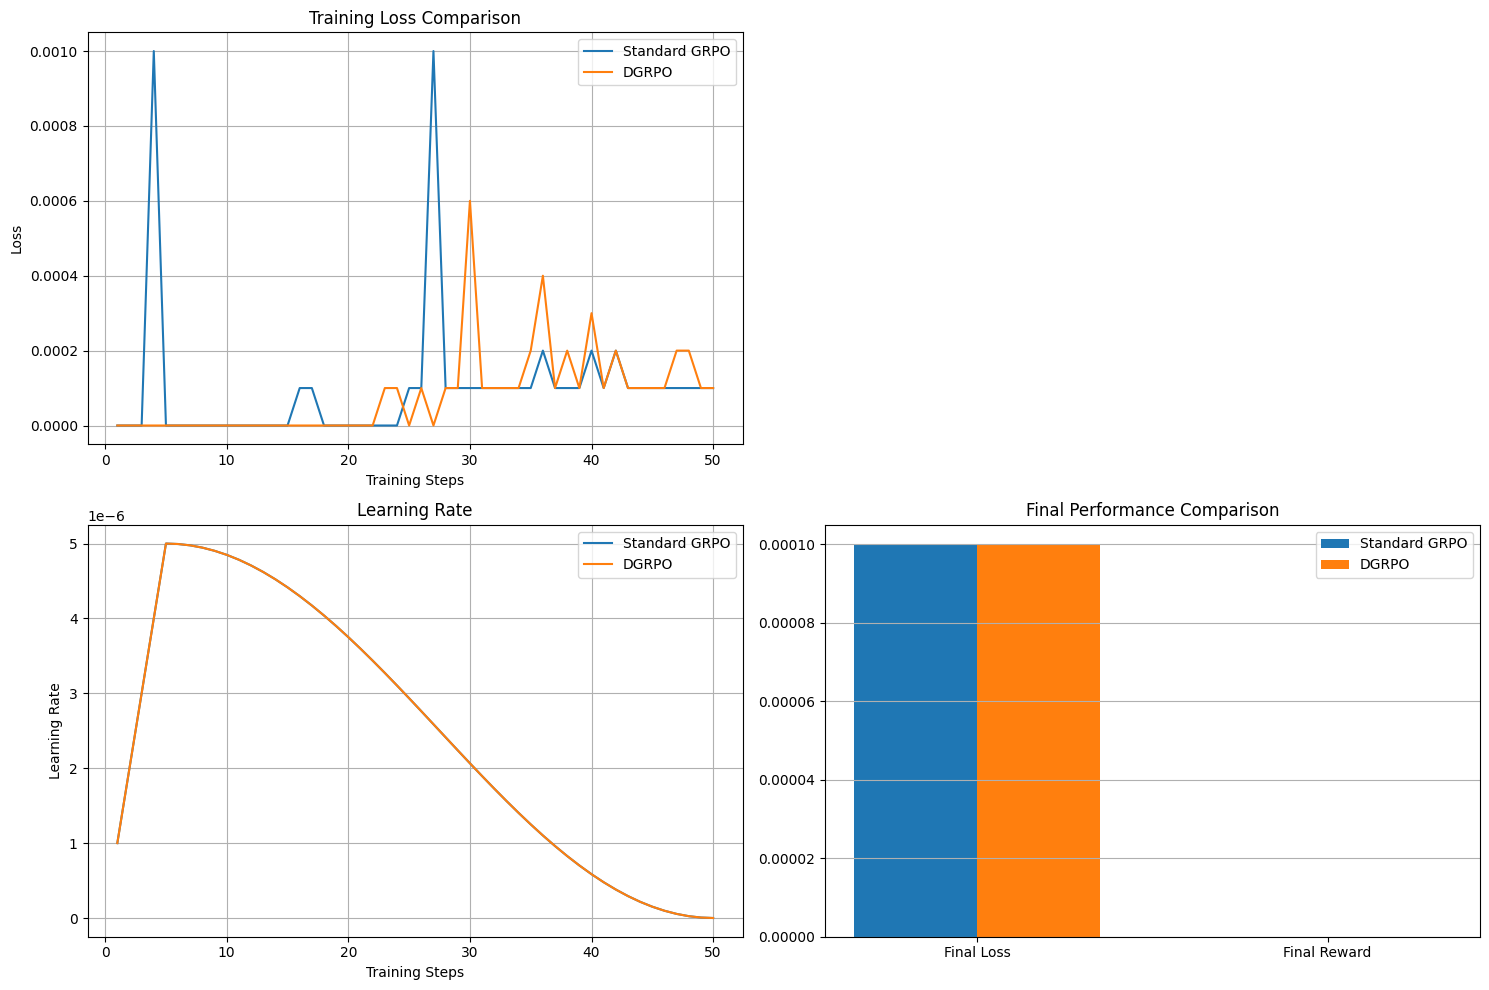


Statistical Comparison:
Standard GRPO Final Loss: 0.0001
DGRPO Final Loss: 0.0001
DGRPO Loss Improvement: 0.00%


In [23]:
# Combine results manually
comparison_results = {
    "standard": standard_results,
    "dgrpo": dgrpo_results
}

print("Plotting comparison metrics...")
plot_comparison(comparison_results)

In [ ]:
# Test the models and get results
test_results = test_models(comparison_results)

In [ ]:
# Save test model (optional)
# Uncomment to save the test model
# Save the LoRA adapter from test run
test_lora_dir = "/content/drive/MyDrive/grpo_model/test_lora"
os.makedirs(test_lora_dir, exist_ok=True)
model.save_lora(test_lora_dir)
print(f"Test LoRA adapter saved to: {test_lora_dir}")